In [32]:
import pandas as pd
import pickle
import numpy as np
import h5py
import pydot
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Add
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import RMSprop, Adagrad, Adam
from keras.utils import plot_model
from keras.losses import binary_crossentropy
#from keras.metrics import precision as prec_metric
import keras.backend as K
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)
df.head()

,timestamp,segment_id,station_id,hour,weekday,month,pre_dir,street_type,suf_dir,one_way,...,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,icy,hailing,thunderstorm
0,2010-01-01 09:00:00+00:00,21821,72470093141,2,4,1,S,ST,,0,...,16093.0,-7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 18:00:00+00:00,32221,72470093141,11,4,1,S,,,0,...,16093.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-02 09:00:00+00:00,42886,72470093141,2,5,1,E,,,0,...,16093.0,-13.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-03 01:00:00+00:00,28854,72470093141,18,5,1,W,,,0,...,16093.0,-11.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-03 15:00:00+00:00,11320,72470093141,8,6,1,E,,,0,...,16093.0,-8.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
ohe_fields=['one_way','surface_type','hour','weekday','month']
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind Speed
* Road Orientation

In [56]:
feature_transforms = {
    'sinuosity': np.log
}
for feature,transform in feature_transforms.items():
    df_ohe[feature] = transform(df_ohe[feature])

In [57]:
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

scaler = StandardScaler()
'''
# Not using sklearn's scaler because I have a bunch of missing data and was feeling lazy. :)
mean_float = np.nanmean(float_features,axis=0)
std_float = np.nanstd(float_features,axis=0)

float_scaled = (float_features - mean_float) / std_float
'''
float_scaled = scaler.fit_transform(float_features)

for i,fname in enumerate(float_feature_names):
    df_ohe[fname] = float_scaled[:,i]

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [58]:
y = df['target'].values
drop_columns = ['index',
                'join_key',
                'segment_id',
                'station_id',
                'timestamp',
                'target',
                'fid',
                'COFIPS',
                'street_type',
                'pre_dir',
                'surface_type',
                'suf_dir']
df_ohe = df_ohe.drop(columns=drop_columns,errors='ignore')

In [59]:
X = df_ohe.values
y = df['target'].values

In [60]:
feature_names = df_ohe.columns.tolist()
len(feature_names)

76

In [61]:
print(feature_names)

['speed_limit', 'surface_width', 'aadt', 'sinuosity', 'euclidean_length', 'segment_length', 'near_major_road', 'road_orient_approx', 'at_intersection', 'near_billboard', 'accident_counts', 'wind_speed', 'visibility', 'temperature', 'precip_depth', 'snow_depth', 'snowing', 'raining', 'foggy', 'icy', 'hailing', 'thunderstorm', 'one_way_0', 'one_way_1', 'one_way_2', 'surface_type_ ', 'surface_type_100', 'surface_type_200', 'surface_type_300', 'surface_type_DIRT', 'surface_type_IMPROVED', 'surface_type_OTHER', 'surface_type_PAVED', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'

In [62]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names,
    'feature_transforms': feature_transforms 
}
with open('wrangler_nn.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [63]:
# create model
model = Sequential()
model.add(Dense(25, input_dim=X.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [64]:
main_input = Input((X.shape[1],),name='input')

dense_00 = Dense(X.shape[1], activation='relu')(main_input)
add_00 = Add(name='add_input_1')([dense_00, main_input])
dropout_00 = Dropout(0.1)(add_00)
dense_01 = Dense(X.shape[1], activation='relu')(dropout_00)
add_01 = Add(name='add_input_2')([dense_01, main_input])
dropout_01 = Dropout(0.1)(add_01)
dense_02 = Dense(X.shape[1], activation='relu')(dropout_01)
add_02 = Add(name='add_input_3')([dense_02, main_input])
dropout_02 = Dropout(0.1)(add_02)
dense_03 = Dense(X.shape[1], activation='relu')(dropout_02)
add_03 = Add(name='add_input_4')([dense_03, main_input])
dropout_03 = Dropout(0.1)(add_03)
dense_04 = Dense(X.shape[1], activation='relu')(dropout_03)
add_04 = Add()([dense_04, main_input])
dropout_04 = Dropout(0.1)(add_04)
dense_05 = Dense(50,activation='relu')(dropout_04)
dense_06 = Dense(25,activation='relu')(dense_05)
dense_07 = Dense(15,activation='relu')(dense_06)
output = Dense(1,activation='sigmoid')(dense_07)

model = Model(inputs=[main_input],outputs=[output])

In [35]:
#def custom_loss(y_true,y_pred):
#    K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

Help on function binary_crossentropy in module keras.losses:

binary_crossentropy(y_true, y_pred)



In [65]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')

sample_weight = ((4.0*y_train > 0) + 1.0*(y_train == 0))/5.0

model.fit(X_train, y_train,
          validation_data=(X_test,y_test), 
          epochs=150, 
          verbose=1, 
          shuffle=True,
          batch_size=100000, 
          sample_weight = sample_weight,
          callbacks=[tensorboard,early_stopping])

Train on 1774046 samples, validate on 197117 samples
Epoch 1/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.1091 - val_loss: 0.5010
Epoch 2/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0998 - val_loss: 0.4889
Epoch 3/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0980 - val_loss: 0.4832
Epoch 4/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0970 - val_loss: 0.4793
Epoch 5/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0963 - val_loss: 0.4756
Epoch 6/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0956 - val_loss: 0.4727
Epoch 7/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0950 - val_loss: 0.4698
Epoch 8/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0946 - val_loss: 0.4679
Epoch 9/150
1774046/1774046 [==============================] - 5s 3us/step 

1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0897 - val_loss: 0.4460
Epoch 76/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.0896 - val_loss: 0.4441
Epoch 77/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.0896 - val_loss: 0.4436
Epoch 78/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.0895 - val_loss: 0.4438
Epoch 79/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.0896 - val_loss: 0.4435
Epoch 80/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0894 - val_loss: 0.4426
Epoch 81/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0894 - val_loss: 0.4428
Epoch 82/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0893 - val_loss: 0.4425
Epoch 83/150
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.0893 - val_loss: 0.4420
Epoch 84/150
1774046/17

1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0879 - val_loss: 0.4380
Epoch 150/150
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.0879 - val_loss: 0.4383


In [67]:
model.save('logloss.h5')

In [68]:
y_pred = model.predict(X_test)

In [69]:
ypt = y_pred>0.1
'''
print ('Test Accuracy:',accuracy_score(y,ypt))
print ('Test F1:',f1_score(y,ypt))
print ('Test Precision:',precision_score(y,ypt))
print ('Test AP:',average_precision_score(y,ypt))
print ('Test Recall:',recall_score(y,ypt))
print ('Test AUC:',roc_auc_score(y,y_pred))
'''
#'''
print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,y_pred))
#'''

Test Accuracy: 0.43640071632583693
Test F1: 0.4177441418021918
Test Precision: 0.2649888626616576
Test AP: 0.2641676426623615
Test Recall: 0.9863139137751818
Test AUC: 0.7290560052691666


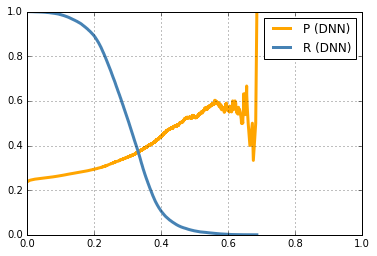

In [70]:
precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

plt.plot(thresholds,precision[:-1],'r-',label='P (DNN)',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (DNN)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.grid()
plt.legend()

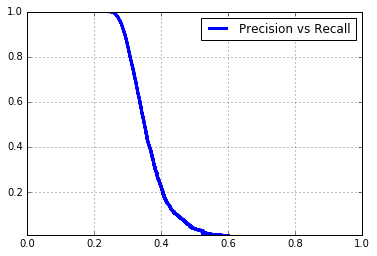

In [71]:
plt.figure(figsize=(15,15))

precision,recall,thresholds = precision_recall_curve(y_test,y_pred)
#precision,recall,thresholds = precision_recall_curve(y,y_pred)

fig,ax = plt.subplots()
plt.plot(precision,recall,label='Precision vs Recall',lw=3)

ax.set_xbound(lower=0.0,upper=1.0)
ax.set_ybound(lower=0.01,upper=1.0)
plt.grid()
plt.legend()

(array([3.3275e+04, 2.4500e+03, 1.4490e+03, 1.8270e+03, 2.0940e+03,
        2.2950e+03, 2.4990e+03, 2.9250e+03, 3.2780e+03, 3.3740e+03,
        3.4750e+03, 3.6210e+03, 4.0570e+03, 4.8090e+03, 5.5360e+03,
        7.1390e+03, 8.5320e+03, 9.2400e+03, 9.2940e+03, 9.0170e+03,
        9.0050e+03, 8.6960e+03, 8.6470e+03, 8.5780e+03, 8.7220e+03,
        7.6870e+03, 6.2790e+03, 5.2590e+03, 3.7730e+03, 2.7450e+03,
        1.8350e+03, 1.3450e+03, 1.0870e+03, 7.5800e+02, 5.7100e+02,
        4.3900e+02, 3.4800e+02, 2.4300e+02, 1.6700e+02, 1.8100e+02,
        1.5500e+02, 1.1100e+02, 1.0900e+02, 8.1000e+01, 4.6000e+01,
        2.9000e+01, 1.3000e+01, 1.6000e+01, 2.0000e+00, 4.0000e+00]),
 array([3.08848513e-07, 1.37267433e-02, 2.74531778e-02, 4.11796123e-02,
        5.49060468e-02, 6.86324813e-02, 8.23589158e-02, 9.60853503e-02,
        1.09811785e-01, 1.23538219e-01, 1.37264654e-01, 1.50991088e-01,
        1.64717523e-01, 1.78443957e-01, 1.92170392e-01, 2.05896826e-01,
        2.19623261e-01, 2.3334

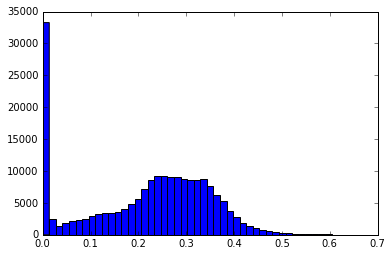

In [72]:
plt.figure()
plt.hist(y_pred,50)